In [18]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
def difference(dataset, columns, interval=1):
    for c in columns:
        difference = np.diff(data[c])
        difference = np.insert(difference, 0, 0)
        dataset[c + ' Difference'] = difference
    return dataset

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [12]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

In [13]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [14]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

In [15]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [16]:
diff_data = difference(data, ['Weighted Price'])
diff_data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Weighted Price Difference
Date,,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522,0.000000
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269,-2.679253
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913,-7.583357
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794,13.365881
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709,45.732916


In [17]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price Difference'], name= 'Price')
py.iplot([btc_trace])

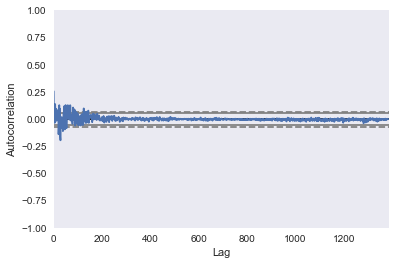

In [19]:
autocorrelation_plot(data['Weighted Price Difference'])

In [57]:
values = data['Weighted Price Difference'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [58]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

(968, 416)


In [59]:
print train, test

[[ 0.46791795]
 [ 0.46477851]
 [ 0.45903206]
 [ 0.48357958]
 [ 0.52150601]
 [ 0.432511  ]
 [ 0.43488032]
 [ 0.48288852]
 [ 0.47315961]
 [ 0.46512386]
 [ 0.41995168]
 [ 0.4902381 ]
 [ 0.46430174]
 [ 0.49192217]
 [ 0.46128714]
 [ 0.45985794]
 [ 0.46179301]
 [ 0.46032023]
 [ 0.46736115]
 [ 0.48343262]
 [ 0.43429706]
 [ 0.47103629]
 [ 0.46744251]
 [ 0.46508256]
 [ 0.47262567]
 [ 0.49215797]
 [ 0.46859041]
 [ 0.44836938]
 [ 0.46354729]
 [ 0.46388349]
 [ 0.43761712]
 [ 0.39519748]
 [ 0.4583458 ]
 [ 0.48278287]
 [ 0.39300221]
 [ 0.51052386]
 [ 0.4504641 ]
 [ 0.40596879]
 [ 0.49573573]
 [ 0.48479375]
 [ 0.4293285 ]
 [ 0.46739176]
 [ 0.47671765]
 [ 0.45619771]
 [ 0.4393307 ]
 [ 0.42907321]
 [ 0.50130498]
 [ 0.49476835]
 [ 0.42420006]
 [ 0.3886418 ]
 [ 0.55632073]
 [ 0.46913898]
 [ 0.45542213]
 [ 0.45915911]
 [ 0.47641519]
 [ 0.52331066]
 [ 0.53637701]
 [ 0.45145625]
 [ 0.46489483]
 [ 0.44875166]
 [ 0.45779434]
 [ 0.46575731]
 [ 0.47481537]
 [ 0.42540082]
 [ 0.49811637]
 [ 0.47623387]
 [ 0.45653

In [60]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

967
415


In [61]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [70]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=300, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 967 samples, validate on 415 samples
Epoch 1/500
1s - loss: 0.4644 - val_loss: 0.4626
Epoch 2/500
0s - loss: 0.4398 - val_loss: 0.4378
Epoch 3/500
0s - loss: 0.4153 - val_loss: 0.4129
Epoch 4/500
0s - loss: 0.3905 - val_loss: 0.3877
Epoch 5/500
0s - loss: 0.3653 - val_loss: 0.3619
Epoch 6/500
0s - loss: 0.3393 - val_loss: 0.3353
Epoch 7/500
0s - loss: 0.3122 - val_loss: 0.3075
Epoch 8/500
0s - loss: 0.2839 - val_loss: 0.2782
Epoch 9/500
0s - loss: 0.2539 - val_loss: 0.2475
Epoch 10/500
0s - loss: 0.2222 - val_loss: 0.2153
Epoch 11/500
0s - loss: 0.1883 - val_loss: 0.1817
Epoch 12/500
0s - loss: 0.1522 - val_loss: 0.1463
Epoch 13/500
0s - loss: 0.1135 - val_loss: 0.1112
Epoch 14/500
0s - loss: 0.0721 - val_loss: 0.0786
Epoch 15/500
0s - loss: 0.0295 - val_loss: 0.0573
Epoch 16/500
0s - loss: 0.0197 - val_loss: 0.0663
Epoch 17/500
0s - loss: 0.0345 - val_loss: 0.0660
Epoch 18/500
0s - loss: 0.0287 - val_loss: 0.0587
Epoch 19/500
0s - loss: 0.0130 - val_loss: 0.0603
Epoch 20/500


0s - loss: 0.0108 - val_loss: 0.0572
Epoch 164/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 165/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 166/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 167/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 168/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 169/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 170/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 171/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 172/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 173/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 174/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 175/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 176/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 177/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 178/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 179/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 180/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 181/500
0s - loss: 0.0108 - val_loss: 0.0572
Epoch 182/500
0s - loss: 0.0107 - val_loss: 0

0s - loss: 0.0106 - val_loss: 0.0574
Epoch 331/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 332/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 333/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 334/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 335/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 336/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 337/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 338/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 339/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 340/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 341/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 342/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 343/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 344/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 345/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 346/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 347/500
0s - loss: 0.0108 - val_loss: 0.0571
Epoch 348/500
0s - loss: 0.0106 - val_loss: 0.0574
Epoch 349/500
0s - loss: 0.0107 - val_loss: 0

0s - loss: 0.0105 - val_loss: 0.0576
Epoch 497/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 498/500
0s - loss: 0.0105 - val_loss: 0.0576
Epoch 499/500
0s - loss: 0.0107 - val_loss: 0.0573
Epoch 500/500
0s - loss: 0.0105 - val_loss: 0.0576


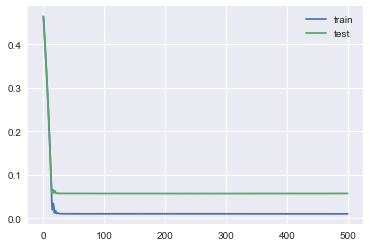

In [71]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

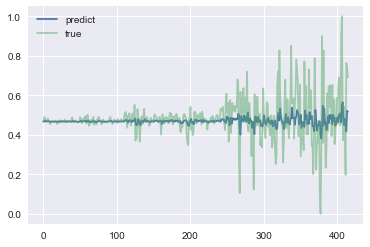

In [72]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true', alpha=0.5)
pyplot.legend()
pyplot.show()